# Basics with string sequence

## Environment and data

_

In [1]:
# Standard library imports
import random

# Related third party imports
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.maths import relu, softmax
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.network.models import EpyNN
from nnlibs.embedding.models import Embedding
from nnlibs.flatten.models import Flatten
from nnlibs.rnn.models import RNN
from nnlibs.gru.models import GRU
from nnlibs.lstm.models import LSTM
from nnlibs.dense.models import Dense
from prepare_dataset import prepare_dataset
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=480)

_

## Feed-Forward (FF)

_

### Embedding

_

In [2]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

_

### Flatten-Dense - Perceptron

_

In [3]:
name = 'Flatten_Dense-2-softmax'

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, flatten, dense]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='MSE', seed=1)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


_

In [4]:
model.initialize(loss='MSE', seed=1)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


_

In [5]:
model.train(epochs=100, init_logs=False)

+-------+----------+-------+----------+-------+-------+------------------------------------+
| epoch |  lrate   |       | accuracy |       |  MSE  |             Experiment             |
|       |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                    |
+-------+----------+-------+----------+-------+-------+------------------------------------+
|   0   | 1.00e-01 | 0.688 |  0.662   | 0.256 | 0.278 | 1628626855_Flatten_Dense-2-softmax |
|  10   | 1.00e-01 | 0.756 |  0.681   | 0.205 | 0.249 | 1628626855_Flatten_Dense-2-softmax |
|  20   | 1.00e-01 | 0.766 |  0.669   | 0.186 | 0.233 | 1628626855_Flatten_Dense-2-softmax |
|  30   | 1.00e-01 | 0.766 |  0.694   | 0.180 | 0.220 | 1628626855_Flatten_Dense-2-softmax |
|  40   | 1.00e-01 | 0.778 |  0.731   | 0.178 | 0.215 | 1628626855_Flatten_Dense-2-softmax |
|  50   | 1.00e-01 | 0.778 |  0.731   | 0.178 | 0.217 | 1628626855_Flatten_Dense-2-softmax |
|  60   | 1.00e-01 | 0.784 |  0.725   | 0.177 | 0.218 | 1628626855_Fla

_

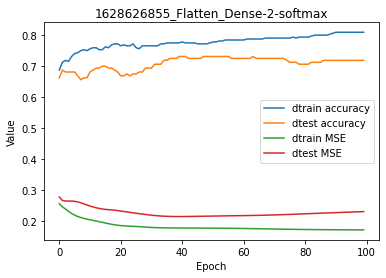

In [6]:
model.plot(path=False)

### Multiple layers

_

In [7]:
name = 'Flatten_Dense-16-relu_Dense-2-softmax'

flatten = Flatten()

hidden_dense = Dense(16, relu)

dense = Dense(2, softmax)

layers = [embedding, flatten, hidden_dense, dense]

model = EpyNN(layers=layers, name=name)

_

In [8]:
model.initialize(loss='BCE', seed=1)

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


_

In [9]:
model.train(epochs=100, init_logs=False)

+-------+----------+----------+-------+----------+-------+-------+--------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  BCE  |                    Experiment                    |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                  |
+-------+----------+----------+-------+----------+-------+-------+--------------------------------------------------+
|   0   | 1.00e-01 | 1.00e-01 | 0.734 |  0.762   | 0.570 | 0.553 | 1628626856_Flatten_Dense-16-relu_Dense-2-softmax |
|  10   | 1.00e-01 | 1.00e-01 | 0.950 |  0.862   | 0.122 | 0.468 | 1628626856_Flatten_Dense-16-relu_Dense-2-softmax |
|  20   | 1.00e-01 | 1.00e-01 | 1.000 |  0.931   | 0.006 | 0.137 | 1628626856_Flatten_Dense-16-relu_Dense-2-softmax |
|  30   | 1.00e-01 | 1.00e-01 | 1.000 |  0.950   | 0.003 | 0.113 | 1628626856_Flatten_Dense-16-relu_Dense-2-softmax |
|  40   | 1.00e-01 | 1.00e-01 | 1.000 |  0.956   | 0.002

_

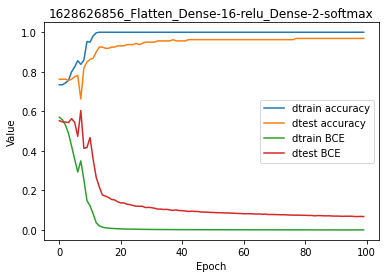

In [10]:
model.plot(path=False)

## Recurrent Architectures

_

### Embedding

_

In [11]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      batch_size=None,
                      relative_size=(2, 1, 0))

_

### RNN + Single-layer FF

_

In [12]:
name = 'RNN-12-Seq_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.01
se_hPars['schedule'] = 'exp_decay'

rnn = RNN(12, sequences=True)

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, rnn, flatten, dense]

model = EpyNN(layers=layers, name=name)

_

In [13]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy())

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: RNN
compute_shapes: RNN
initialize_parameters: RNN
forward: RNN
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: RNN
backward: RNN
compute_gradients: RNN
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


_

In [14]:
model.train(epochs=200, init_logs=False)

+-------+----------+----------+-------+----------+-------+-------+-----------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                  Experiment                   |
|       |   RNN    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                               |
+-------+----------+----------+-------+----------+-------+-------+-----------------------------------------------+
|   0   | 1.00e-02 | 1.00e-02 | 0.506 |  0.431   | 0.441 | 0.494 | 1628626857_RNN-12-Seq_Flatten_Dense-2-softmax |
|  20   | 6.07e-03 | 6.07e-03 | 0.675 |  0.706   | 0.272 | 0.256 | 1628626857_RNN-12-Seq_Flatten_Dense-2-softmax |
|  40   | 3.68e-03 | 3.68e-03 | 0.709 |  0.706   | 0.250 | 0.240 | 1628626857_RNN-12-Seq_Flatten_Dense-2-softmax |
|  60   | 2.23e-03 | 2.23e-03 | 0.725 |  0.719   | 0.241 | 0.235 | 1628626857_RNN-12-Seq_Flatten_Dense-2-softmax |
|  80   | 1.35e-03 | 1.35e-03 | 0.728 |  0.725   | 0.236 | 0.234 | 1628626857_RN

_

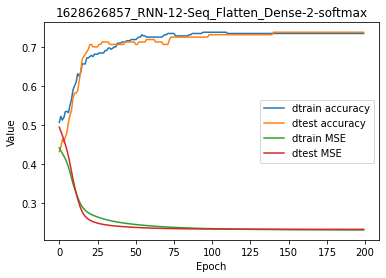

In [15]:
model.plot(path=False)

_

### LSTM + Single-layer FF

_

In [16]:
name = 'LSTM-12-Seq_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.005
se_hPars['schedule'] = 'steady'

lstm = LSTM(12, sequences=True)

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, lstm, flatten, dense]

model = EpyNN(layers=layers, name=name)

_

In [17]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy())

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: LSTM
compute_shapes: LSTM
initialize_parameters: LSTM
forward: LSTM
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: LSTM
backward: LSTM
compute_gradients: LSTM
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


_

In [18]:
model.train(epochs=200, init_logs=False)

+-------+----------+----------+-------+----------+-------+-------+------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                   Experiment                   |
|       |   LSTM   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                |
+-------+----------+----------+-------+----------+-------+-------+------------------------------------------------+
|   0   | 5.00e-03 | 5.00e-03 | 0.559 |  0.562   | 0.272 | 0.249 | 1628626860_LSTM-12-Seq_Flatten_Dense-2-softmax |
|  20   | 5.00e-03 | 5.00e-03 | 0.712 |  0.744   | 0.215 | 0.191 | 1628626860_LSTM-12-Seq_Flatten_Dense-2-softmax |
|  40   | 5.00e-03 | 5.00e-03 | 0.716 |  0.744   | 0.212 | 0.189 | 1628626860_LSTM-12-Seq_Flatten_Dense-2-softmax |
|  60   | 5.00e-03 | 5.00e-03 | 0.722 |  0.744   | 0.210 | 0.188 | 1628626860_LSTM-12-Seq_Flatten_Dense-2-softmax |
|  80   | 5.00e-03 | 5.00e-03 | 0.722 |  0.744   | 0.207 | 0.187 | 16286

_

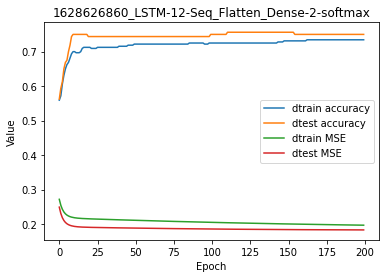

In [19]:
model.plot(path=False)

_

### GRU + Single-layer FF

_

In [20]:
name = 'GRU-12-Seq_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.005
se_hPars['schedule'] = 'steady'

gru = GRU(12, sequences=True)

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, gru, flatten, dense]

model = EpyNN(layers=layers, name=name)

_

In [21]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy())

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: GRU
compute_shapes: GRU
initialize_parameters: GRU
forward: GRU
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: GRU
backward: GRU
compute_gradients: GRU
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


_

In [22]:
model.train(epochs=200, init_logs=False)

+-------+----------+----------+-------+----------+-------+-------+-----------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  MSE  |                  Experiment                   |
|       |   GRU    |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                               |
+-------+----------+----------+-------+----------+-------+-------+-----------------------------------------------+
|   0   | 5.00e-03 | 5.00e-03 | 0.503 |  0.500   | 0.354 | 0.331 | 1628626869_GRU-12-Seq_Flatten_Dense-2-softmax |
|  20   | 5.00e-03 | 5.00e-03 | 0.706 |  0.731   | 0.234 | 0.212 | 1628626869_GRU-12-Seq_Flatten_Dense-2-softmax |
|  40   | 5.00e-03 | 5.00e-03 | 0.716 |  0.738   | 0.226 | 0.208 | 1628626869_GRU-12-Seq_Flatten_Dense-2-softmax |
|  60   | 5.00e-03 | 5.00e-03 | 0.716 |  0.738   | 0.220 | 0.205 | 1628626869_GRU-12-Seq_Flatten_Dense-2-softmax |
|  80   | 5.00e-03 | 5.00e-03 | 0.731 |  0.738   | 0.214 | 0.202 | 1628626869_GR

_

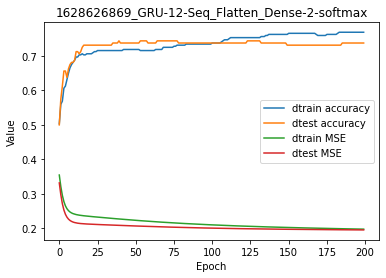

In [23]:
model.plot(path=False)